<a href="https://colab.research.google.com/github/prc98/title-generation/blob/main/NLP_Title_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

## Project Description - Given the abstract of a technical paper, generate a suitable title for it

## Dataset - https://www.kaggle.com/neelshah18/arxivdataset

## References - 


## Rough Plan 
1. Prepare dataset
2. Try out word-level RNN as a baseline model
3. Use seq2seq attention based model ( Ref :https://www.ijcai.org/Proceedings/2017/0574.pdf / https://arxiv.org/abs/1512.01712)
4. Use pretrained models (GPT-2 or GPT-3 or google T-5) and compare the performance.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded=files.upload()

### 1. Read the dataset



In [ ]:
import pandas as pd
import json
import matplotlib as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit


torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
f=open("./arxivData.json")
data=json.load(f)
summary=[]
title=[]
for i in data:
    summary.append(i['summary'])
    title.append(i['title'])
d={'summary':summary,'title':title}
df=pd.DataFrame({'Abstract':d['summary'],'Title':d['title']})
df.to_csv('data.csv',index=False)


FileNotFoundError: ignored

In [ ]:
df=pd.read_csv("./drive/MyDrive/data.csv")
df.head()

,Abstract,Title
0,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...
1,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...
2,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...
3,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...
4,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot


### 2. Data Preprocessing

#### Remove duplicates from dataset

In [ ]:
has_duplicate = df.duplicated()

#gets duplicate rows

duplicates = df[has_duplicate].head()
print(duplicates)

                                                Abstract                                              Title
10066  Distributed training of deep learning models o...             Revisiting Distributed Synchronous SGD
10261  The problem of clustering is considered, for t...                               Clustering processes
10824  In many applications that require matrix solut...  Non-Convex Rank Minimization via an Empirical ...
10826  Gaussian processes (GP) are Bayesian non-param...  Parallel Gaussian Process Regression with Low-...
10844  In deterministic optimization, line searches a...  Probabilistic Line Searches for Stochastic Opt...


In [ ]:
df.drop_duplicates(subset =None, keep = False, inplace = True)
print(df.describe())

                                                 Abstract                                              Title
count                                               40974                                              40974
unique                                              40955                                              40943
top     Editing on digital images is ubiquitous. Ident...  ERBlox: Combining Matching Dependencies with M...
freq                                                    2                                                  2


#### a. Preprocessing the Abstract part

In [ ]:
df['Abstract'][0]

'We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.'

**STEPS**
    <br>Convert to Lowercase
    <br> Split into words
    <br>Remove stopwords
    <br>Eliminate punctuations and special characters
    


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import string
def remove_punctuation(txt):
    txt_punctuate=[c for c in txt if c not in string.punctuation]
    return "".join(txt_punctuate)
#ds['Abstract']=ds['Abstract'].apply(lambda x:remove_punctuation(x))
#ds['Title']=ds['Title'].apply(lambda x:remove_punctuation(x))

In [ ]:
def abstract_cleaner(df):
  df['cleanAbstract'] = df['Abstract'].str.lower().str.split()
  df['cleanAbstract']=df['cleanAbstract'].apply(lambda x: [item for item in x if item not in stop])
  df['cleanAbstract']=df['cleanAbstract'].apply(lambda x:[remove_punctuation(w) for w in x] )
  print(df['cleanAbstract'][0])

In [ ]:
abstract_cleaner(df)
df

['propose', 'architecture', 'vqa', 'utilizes', 'recurrent', 'layers', 'generate', 'visual', 'textual', 'attention', 'memory', 'characteristic', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'rich', 'joint', 'embedding', 'visual', 'textual', 'features', 'enables', 'model', 'reason', 'relations', 'several', 'parts', 'image', 'question', 'single', 'model', 'outperforms', 'first', 'place', 'winner', 'vqa', '10', 'dataset', 'performs', 'within', 'margin', 'current', 'stateoftheart', 'ensemble', 'model', 'also', 'experiment', 'replacing', 'attention', 'mechanisms', 'stateoftheart', 'models', 'implementation', 'show', 'increased', 'accuracy', 'cases', 'recurrent', 'attention', 'mechanism', 'improves', 'performance', 'tasks', 'requiring', 'sequential', 'relational', 'reasoning', 'vqa', 'dataset']


,Abstract,Title,cleanAbstract
0,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...,"[propose, architecture, vqa, utilizes, recurre..."
1,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...,"[recent, approaches, based, artificial, neural..."
2,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...,"[introduce, multiresolution, recurrent, neural..."
3,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...,"[multitask, learning, motivated, observation, ..."
4,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot,"[present, milabot, deep, reinforcement, learni..."
...,...,...,...
40995,We study the complexity of learning and approx...,Nearly Tight Bounds on $\ell_1$ Approximation ...,"[study, complexity, learning, approximation, s..."
40996,We consider the problem of multiple users targ...,Concurrent bandits and cognitive radio networks,"[consider, problem, multiple, users, targeting..."
40997,"In this paper, we compare and analyze clusteri...",A Comparison of Clustering and Missing Data Me...,"[paper, compare, analyze, clustering, methods,..."
40998,Cylindrical algebraic decomposition(CAD) is a ...,Applying machine learning to the problem of ch...,"[cylindrical, algebraic, decompositioncad, key..."


#### b. Preprocessing the Title part

In [ ]:
def title_cleaner(df):
  df['cleanTitle'] = df['Title'].str.lower().str.split()
  #df['cleanAbstract']=df['cleanAbstract'].apply(lambda x: [item for item in x if item not in stop])
  df['cleanTitle']=df['cleanTitle'].apply(lambda x:[remove_punctuation(w) for w in x] )
  print(df['cleanTitle'][0])

In [ ]:
title_cleaner(df)

['dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering']


In [ ]:
df

,Abstract,Title,cleanAbstract,cleanTitle
0,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...,"[propose, architecture, vqa, utilizes, recurre...","[dual, recurrent, attention, units, for, visua..."
1,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...,"[recent, approaches, based, artificial, neural...","[sequential, shorttext, classification, with, ..."
2,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...,"[introduce, multiresolution, recurrent, neural...","[multiresolution, recurrent, neural, networks,..."
3,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...,"[multitask, learning, motivated, observation, ...","[learning, what, to, share, between, loosely, ..."
4,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot,"[present, milabot, deep, reinforcement, learni...","[a, deep, reinforcement, learning, chatbot]"
...,...,...,...,...
40995,We study the complexity of learning and approx...,Nearly Tight Bounds on $\ell_1$ Approximation ...,"[study, complexity, learning, approximation, s...","[nearly, tight, bounds, on, ell1, approximatio..."
40996,We consider the problem of multiple users targ...,Concurrent bandits and cognitive radio networks,"[consider, problem, multiple, users, targeting...","[concurrent, bandits, and, cognitive, radio, n..."
40997,"In this paper, we compare and analyze clusteri...",A Comparison of Clustering and Missing Data Me...,"[paper, compare, analyze, clustering, methods,...","[a, comparison, of, clustering, and, missing, ..."
40998,Cylindrical algebraic decomposition(CAD) is a ...,Applying machine learning to the problem of ch...,"[cylindrical, algebraic, decompositioncad, key...","[applying, machine, learning, to, the, problem..."


In [ ]:
df.to_csv('clean_data.csv',index=False)


In [ ]:
import numpy as np
df['cleanAbstract'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
df['cleanTitle'] = df['cleanTitle'].apply(lambda x : ['_START_'] + x + ['_END_'])

#### Visualize the distribution of abstract lengths

In [ ]:
ab_len = []
df['cleanAbstract'].apply(lambda x : [ab_len.append(len(x))])
print(len(ab_len))
#plt.pyplot.hist(len(ab_len))

40974


(array([9.4200e+02, 7.1550e+03, 1.4635e+04, 1.1842e+04, 4.8370e+03,
        1.4970e+03, 5.1000e+01, 8.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  2. ,  33.3,  64.6,  95.9, 127.2, 158.5, 189.8, 221.1, 252.4,
        283.7, 315. ]),
 <a list of 10 Patch objects>)

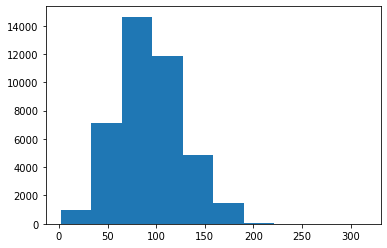

In [ ]:
plt.pyplot.hist(ab_len)

In [ ]:
max_len_ab =max(ab_len)
print(max_len_ab)

315


#### Visualize the distribution of titla

In [ ]:
t_len = []
df['cleanTitle'].apply(lambda x : [t_len.append(len(x))])
print(len(t_len))

40974


(array([2.9210e+03, 1.2829e+04, 1.4634e+04, 7.4370e+03, 2.3950e+03,
        6.3100e+02, 9.4000e+01, 2.4000e+01, 7.0000e+00, 2.0000e+00]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

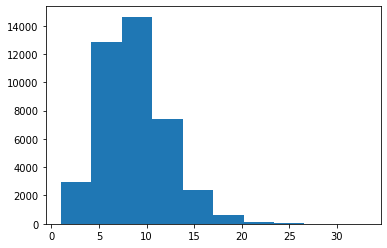

In [ ]:
plt.pyplot.hist(t_len)

In [ ]:
max_len_t =max(t_len)
print(max_len_t)

35


ADD

In [ ]:
df['cleanTitle'][0]

['_START_',
 'dual',
 'recurrent',
 'attention',
 'units',
 'for',
 'visual',
 'question',
 'answering',
 '_END_']

#### train & test datasets

In [ ]:
from sklearn.model_selection import train_test_split
abstract_t,abstract_v,title_t,title_v=train_test_split(df['cleanAbstract'],df['cleanTitle'],test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
#### Building Vocabulary

In [ ]:
unique_words =set()
abstract_t.apply(lambda x : {unique_words.add(w) for w in x} )
print(len(unique_words))
title_t.apply(lambda x :  {unique_words.add(w) for w in x})
unique_words.remove('')
print("Number of unique words : ", len(unique_words))
vocab_train = len(unique_words)

88948
Number of unique words :  92161


In [ ]:
print(list(unique_words))

['conflictual', 'aside', 'mmg', 'hao', 'refined', 'alobased', 'lugosi', '202', 'demystification', 'throttles', 'domainknowledge', 'antibiotic', 'gijbf', 'wellconnected', 'recharacterizes', 'tried', 'aneuploidy', '3d1', 'rearrange', 'httpsiamacewhitegithubiosuppindexhtml', 'graphons', 'dalia1', 'elmcl', 'featuresand', 'lta', 'kolog', 'runtimes', 'msrestcn', 'playerś', 'emphadaptively', 'wavelettreebased', 'methodsit', 'gcgm', '2mass', 'ssmdp', 'adagrad', 'cessive', 'trial', 'captionquestion', 'destabilizing', 'scnet', 'svmpairwise', 'lin', 'scientific', 'cubical', 'chips', 'gausians', 'vibration', 'performed', 'mentor', '903', 'featurewise', 'driu', 'electromagnetism', 'posttranscriptional', 'scenecut', 'superposition', 'epsilonstationarity', 'closestpa', 'sympascal', 'shri', 'tnr', '1safe', 'betail', 'melanin', 'stableanswer', 'motivations', 'revocability', 'attributevalue', 'polytrees', 'polyadic', 'mispronunciation', 'accustomed', 'errata', 'heldouttest', 'preassembling', 'means', '8

In [ ]:
unique_words=list(unique_words)
unique_words=["<pad>"]+["<unk>"]+unique_words
print(unique_words)
def wrd_to_idx(): #return a diction mapping words -> index
  wrd_idx = dict((word, idx) for idx,word in enumerate(unique_words))
  #wrd_idx['_START_']=start
  #wrd_idx['_END_'] = end
  return wrd_idx


['<pad>', '<unk>', 'conflictual', 'aside', 'mmg', 'hao', 'refined', 'alobased', 'lugosi', '202', 'demystification', 'throttles', 'domainknowledge', 'antibiotic', 'gijbf', 'wellconnected', 'recharacterizes', 'tried', 'aneuploidy', '3d1', 'rearrange', 'httpsiamacewhitegithubiosuppindexhtml', 'graphons', 'dalia1', 'elmcl', 'featuresand', 'lta', 'kolog', 'runtimes', 'msrestcn', 'playerś', 'emphadaptively', 'wavelettreebased', 'methodsit', 'gcgm', '2mass', 'ssmdp', 'adagrad', 'cessive', 'trial', 'captionquestion', 'destabilizing', 'scnet', 'svmpairwise', 'lin', 'scientific', 'cubical', 'chips', 'gausians', 'vibration', 'performed', 'mentor', '903', 'featurewise', 'driu', 'electromagnetism', 'posttranscriptional', 'scenecut', 'superposition', 'epsilonstationarity', 'closestpa', 'sympascal', 'shri', 'tnr', '1safe', 'betail', 'melanin', 'stableanswer', 'motivations', 'revocability', 'attributevalue', 'polytrees', 'polyadic', 'mispronunciation', 'accustomed', 'errata', 'heldouttest', 'preassemb

In [ ]:
def idx_to_wrd(wrd_idx):
  idx_wrd= dict((idx,word) for word,idx in wrd_idx.iteritems())
  return idx_wrd


#### convert list of words in to list of indices

In [ ]:
def convert(sen):
  con_wrd = []
  for w in sen:
    if(w not in wrd_idx):
      con_wrd.append(1)#out of vocabulary
    else:
      con_wrd.append(wrd_idx[w])
  return con_wrd



In [ ]:
df_train = pd.DataFrame()
df_test=pd.DataFrame()

In [ ]:
wrd_idx=wrd_to_idx()
abstract_t = abstract_t.apply(lambda x: convert(x))
title_t= title_t.apply(lambda x: convert(x))
abstract_v = abstract_v.apply(lambda x: convert(x))
title_v = title_v.apply(lambda x: convert(x))

In [ ]:
abstract_t

505      [74306, 36235, 40053, 13915, 89253, 50541, 853...
28297    [59851, 74596, 79740, 88381, 9004, 56409, 5747...
26502    [22714, 31285, 39876, 14479, 80931, 63055, 762...
25943    [29931, 62814, 23531, 70236, 52434, 31751, 556...
32968    [39540, 27058, 88381, 46343, 27142, 72200, 485...
                               ...                        
20779    [91249, 25607, 78522, 10550, 65314, 68959, 127...
32126    [26593, 8128, 54488, 7823, 2939, 26593, 26066,...
30426    [59670, 17868, 62512, 15609, 20632, 59851, 786...
21265    [803, 90158, 50887, 9750, 25058, 1524, 40714, ...
2732     [17868, 89115, 11431, 39690, 32613, 19356, 761...
Name: cleanAbstract, Length: 36876, dtype: object

In [ ]:
title_t

505      [85959, 89068, 3014, 56375, 16270, 34892, 8128...
28297    [85959, 89068, 40194, 64043, 39540, 70091, 162...
26502                   [85959, 73000, 10014, 83022, 5319]
25943    [85959, 33588, 8411, 23531, 16270, 75842, 3175...
32968    [85959, 24559, 54719, 52334, 27061, 39540, 270...
                               ...                        
20779     [85959, 91249, 15448, 10550, 65314, 68959, 5319]
32126                    [85959, 65556, 26593, 8128, 5319]
30426    [85959, 56570, 60387, 15863, 54719, 63493, 715...
21265    [85959, 2939, 27088, 16270, 25407, 8128, 83369...
2732     [85959, 89115, 11431, 39690, 59736, 805, 53932...
Name: cleanTitle, Length: 36876, dtype: object

#### Padding abstract and title

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#df_train['numericAbstract'] = df_train['numericAbstract'].apply(lambda x: x.zfill(max_len_ab))
abstract_t = pad_sequences(abstract_t,maxlen=max_len_ab,padding="pre",value=0)
title_t = pad_sequences(title_t,maxlen=max_len_t,padding="pre",value=0)
abstract_v = pad_sequences(abstract_v,maxlen=max_len_ab,padding="pre",value=0)
title_v = pad_sequences(title_v,maxlen=max_len_t,padding="pre",value=0)

In [ ]:
abstract_t

array([[    0,     0,     0, ..., 11672, 51486, 87424],
       [    0,     0,     0, ..., 49618, 77776, 46226],
       [    0,     0,     0, ..., 46943, 61372, 87148],
       ...,
       [    0,     0,     0, ..., 55142, 65451, 41797],
       [    0,     0,     0, ..., 58137, 81423, 33769],
       [    0,     0,     0, ..., 53326, 55040, 46226]], dtype=int32)

In [ ]:
df_train['numericalEncodedAbstract']=pd.Series(abstract_t.tolist())
df_train['numericalEncodedTitle']=pd.Series(title_t.tolist())
df_test['numericalEncodedAbstract']=pd.Series(abstract_v.tolist())
df_test['numericalEncodedTitle']=pd.Series(title_v.tolist())

In [ ]:
df_train.head()

,numericalEncodedAbstract,numericalEncodedTitle
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_test.head()

,numericalEncodedAbstract,numericalEncodedTitle
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 85959,..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
len(df_test['numericalEncodedAbstract'][0])

315

In [ ]:
df_train.to_csv('train.csv',index=False)
df_test.to_csv('test.csv',index=False)

In [ ]:
df_train

,numericalEncodedAbstract,numericalEncodedTitle
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
36871,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36872,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36873,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36874,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 3. MODEL

 Input -> Embedding -> Encoder(LSTM) -> Context vector -> Decoder(LSTM) -> Output

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, dropout): 
        super().__init__()   
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers, dropout = dropout,batch_first=True)    
        self.dropout = nn.Dropout(dropout)       
    def forward(self, input_idx):
        embedded = self.dropout(self.embedding(input_idx))  
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        #outputs are always from the top hidden layer
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
  def __init__(self,input_dim,emb_dim,hid_dim,num_layers,dropout,output_dim):
    super().__init__()
    self.hid_dim = hid_dim
    self.num_layers=num_layers
    self.embedding = nn.Embedding(input_dim,emb_dim)
    self.lstm = nn.LSTM(emb_dim,hid_dim,num_layers,dropout=dropout,batch_first=True)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hid_dim,output_dim)   

  def forward(self,input_idx,context_vector,cell_state):
    embedded = self.dropout(self.embedding(input_idx))
    outputs, (hidden, cell) = self.lstm(embedded,(context_vector,cell_state))
    outputs = outputs.view(-1,self.hid_dim)
    prediction = self.fc(outputs)
    return prediction


#### Checking

In [ ]:
ec=Encoder(input_dim=20, emb_dim=10, hid_dim=15, num_layers=3, dropout=0.1)
print(ec)

Encoder(
  (embedding): Embedding(20, 10)
  (lstm): LSTM(10, 15, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
dc= Decoder(input_dim=20, emb_dim=10, hid_dim=15, num_layers=3, dropout=0.1,output_dim=20)
print(dc)

Decoder(
  (embedding): Embedding(20, 10)
  (lstm): LSTM(10, 15, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=15, out_features=20, bias=True)
)


In [ ]:
input_idx =torch.randint(10, (5,2))# 5 abstracts(batches) of 2words each
print(input_idx)

tensor([[0, 8],
        [3, 4],
        [1, 9],
        [3, 3],
        [7, 7]])


In [ ]:
output_idx =torch.randint(10, (5,2))# 5 abstracts(batches) of 2words each
print(output_idx)

tensor([[8, 9],
        [2, 8],
        [6, 1],
        [9, 0],
        [6, 2]])


In [ ]:
h,c= ec(input_idx)
print(op.size())

torch.Size([5, 2, 15])


In [ ]:
class Seq2Seq(nn.Module): #Combining the encoder and decoder
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device =  device
  def forward(self,input_batches,output_batches):
    hidden,cell = self.encoder(input_batches)
    prediction = self.decoder(output_batches,hidden,cell)
    return prediction


In [ ]:
sq=Seq2Seq(ec,dc,"cuda")
pred=sq(input_idx,output_idx)


In [ ]:
print(pred.size())

torch.Size([5, 2, 20])


In [ ]:
output_idx =torch.randint(10, (5,2))# 5 abstracts(batches) of 2words each
print(output_idx)